# Online model selection through bandit learning

---

### 0. Packages imports and functions definitions

#### NB options

In [1085]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Constants

In [1079]:
FIGSIZE = (10, 6)

#### Packages imports

In [1086]:
from collections import namedtuple
import itertools

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm

from river import (
    optim,
    datasets,
    preprocessing,
    linear_model,
    metrics,
    compose
)
from river.expert import (
    EpsilonGreedyRegressor,
    UCBRegressor,
    RandomBanditRegressor,
    OracleBandit
)
from river.stream import iter_sklearn_dataset

### Functions for data generation

In [1074]:
def make_xy_numpy(N=1000, p=10, intercept=0.0, seed=None, drift=False, noise_scale=.5, scale_beta=1, shock=None):
    N = int(N)
    
    if seed:
        np.random.seed(seed)

    beta = np.random.uniform(-1*scale_beta, 1*scale_beta, p)
    
    if shock:
        tier = N // 3
        beta[tier:(2 * tier)] += np.random.uniform(-1, 1, len(beta[tier:(2 * tier)]))
        beta[(2 * tier):] += np.random.uniform(-1, 1, len(beta[(2 * tier):]))

    x_arr = np.random.normal(size=(N, p))
    noise = np.random.normal(size=N, scale=noise_scale)
    xb = intercept + np.sum(x_arr * beta, axis=1) 
    
    if drift:
        tier = N // 3
        xb[tier:(2 * tier)] *= -1
        xb[(2 * tier):] *= -1
        beta *= -1
    
    y_arr = xb + noise

    return x_arr, y_arr, beta


def make_dataset(**kwargs):
    Dataset = namedtuple("dat", ["target", "data", "feature_names", "beta"])
    x_arr, y_arr, beta = make_xy_numpy(**kwargs)
    dataset = Dataset(y_arr, x_arr, ["x{}".format(i) for i in range(p)], beta)
    return dataset


def make_stream(dataset=None, take=None):
    if dataset is None:
        dataset = make_dataset()
    
    gen = iter_sklearn_dataset(dataset)
    
    if take:
        return itertools.islice(gen, take)
    else:
        return gen


### Functions for pipeline/models generation

In [1057]:
l2_val = [1e-4, 1e-3, 1e-2, 1e-1, 1, 2]
lr_val = [0.1, 0.01]
optimz = [optim.Adam]
scalerz = [preprocessing.StandardScaler, preprocessing.MaxAbsScaler, preprocessing.MinMaxScaler, preprocessing.RobustScaler]

def make_models(lr=0.35):
    grid = itertools.product(
        lr_val,
        l2_val,
        scalerz,
        optimz
    )    
    return [make_pipeline(lr=lr, l2=l2, scaler=scaler, optimizer=optimizer)
            for (lr, l2, scaler, optimizer) in grid]

def make_pipeline(lr=0.1, l2=0, scaler=None, optimizer=None):
    if scaler is None:
        scaler =  preprocessing.StandardScaler()
    if optimizer is None:
        optimizer = optim.SGD

    pipeline = compose.Pipeline(
        scaler,
        linear_model.LinearRegression(optimizer=optimizer(), l2=l2)
    )
    return pipeline

# 1. Simulation

## 1.1. Layout

We simulate a **dataset** with : 
- 10 000 observations
- 25 features that are iid $\mathcal{N}(0, 1)$.
- $\beta$ vector is distributed as $\mathcal{U}([0, 1])$
- The data generating process (DGP) is linear : $y=X^T\beta + \epsilon$ with $\epsilon$ ~ $\mathcal{N}(0, 1)$

In [1164]:
N = 15000
p = 25
dataset = make_dataset(p=p, N=N, intercept=2, drift=False, noise_scale=.25, shock=False, seed=123)

In [1165]:
use_oracle = False
use_provided_compute = False

In [1166]:
def make_default_params():
    return dict(metric=metrics.MSE(), 
                reward_scaler=preprocessing.StandardScaler(),
                save_metric_values=True,
                models=make_models(),
                save_percentage_pulled=True,
                print_every=N//3)

In [1177]:
bandits = {
    "epsilon" : EpsilonGreedyRegressor(epsilon=0.3, **make_default_params()),
    "ucb"     : UCBRegressor(delta=None,**make_default_params()),
    "random"  : RandomBanditRegressor(**make_default_params()),
}
bandit_oracle = OracleBandit(**make_default_params())

for _, bandit in bandits.items():
    pass#bandit._compute_scaled_reward = new_compute

for i, (x, y) in tqdm.tqdm(enumerate(make_stream(dataset))):    

    for bandit_label in bandits:
        y_pred = bandits[bandit_label].predict_one(x=x)
        update_internals = False if i < 100 else True
        bandits[bandit_label].learn_one(x=x, y=y)
    
    if use_oracle:
        oracle_pred = bandit_oracle.predict_one(x, y)
        bandit_oracle.learn_one(x=x, y=y)

5133it [00:21, 235.57it/s]

EpsilonGreedyRegressor
	MSE: 4.068043
	Best model id: 19
UCBRegressor
	MSE: 3.096112
	Best model id: 27
RandomBanditRegressor
	MSE: 4.460665
	Best model id: 28


10056it [00:41, 226.44it/s]

EpsilonGreedyRegressor
	MSE: 3.554461
	Best model id: 39
UCBRegressor
	MSE: 1.909781
	Best model id: 33
RandomBanditRegressor
	MSE: 3.308141
	Best model id: 1


15000it [01:05, 230.63it/s]

EpsilonGreedyRegressor
	MSE: 2.922468
	Best model id: 39
UCBRegressor
	MSE: 1.423147
	Best model id: 33
RandomBanditRegressor
	MSE: 2.902202
	Best model id: 1


## 1.2. Results analysis

### Percentages of times the arms were pulled

The arm pulled is the result of the exploitation/exploration process and doesn't necessary represent the best model (max average reward)

In [1178]:
def make_percentage_df(percentage_pulled, threshold=0.5/100):
    times_pulled_df = pd.DataFrame(({i:pct for (i,pct) in enumerate(array)} for array in percentage_pulled))
    most_pulled = times_pulled_df.mean(axis=0)[lambda s: s >= threshold].index
    less_pulled = set(times_pulled_df.columns) - set(most_pulled)
    cleaned_pulled  = pd.concat([times_pulled_df.loc[:,list(most_pulled)],
                                 times_pulled_df[less_pulled].sum(axis=1).rename("other").to_frame()],
                                axis=1)
    return cleaned_pulled

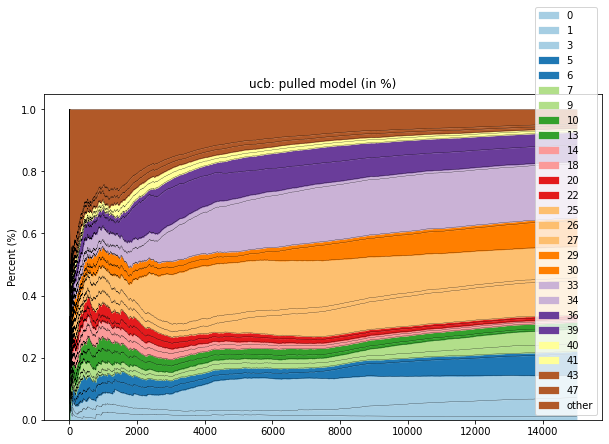

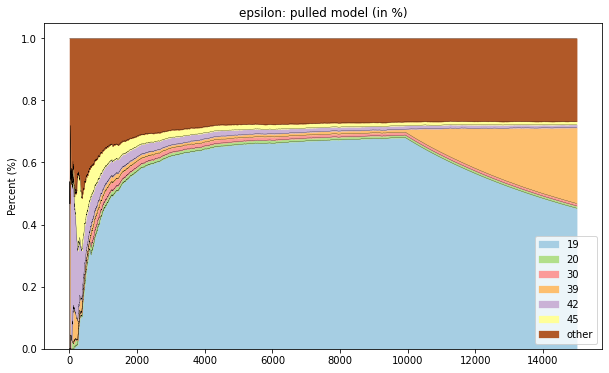

In [1179]:
for bandit_label in ["ucb", "epsilon"]:
    cleaned_pulled = make_percentage_df(bandits[bandit_label].store_percentage_pulled, threshold=1/100)
    
    # plot
    ax = cleaned_pulled.plot(kind="area", colormap="Paired", linewidth=.25, figsize=FIGSIZE, 
                             title=f"{bandit_label}: pulled model (in %)")
    ax.set_ylabel('Percent (%)')
    [l.set_color("black") for l in ax.lines]
    plt.show()

### Comparing bandits loss (lower is better)

In [1180]:
metric_values_dict = {key:value.metric_values for key,value in bandits.items()}
if len(bandit_oracle.metric_values):
    metric_values_dict.update({"oracle": bandit_oracle.metric_values})
metric_values_df = pd.DataFrame(metric_values_dict)

The loss is defined as the squared difference between the target `y` and the prediction `y_pred` that is given by the method `predict_one`. Note that the `predict_one` method returns the prediction of the model with the highest average reward.

<AxesSubplot:title={'center':'Cumsum of loss'}>

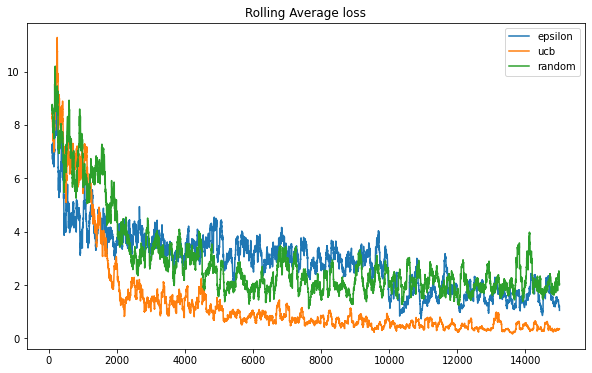

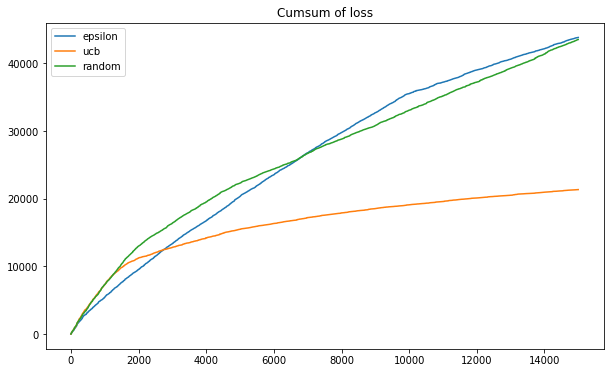

In [1181]:
metric_values_df.rolling(100).mean().plot(title="Rolling Average loss", figsize=FIGSIZE)
metric_values_df.cumsum().plot(title="Cumsum of loss", figsize=FIGSIZE)

### Distangling the effects of learning models from learning selection (bandit)

The loss comparison of the previous section shows that there is decrease in loss the first 4 000 observations that happen for **all** the models (even the random one).

Contrary to classical bandits, the distribution of the rewards the models also depends on **_how well_ we can fit the models**. The model fitting is directly linked to how many observations have been fed to the model : more observations = better fitting. This effect is common for all bandit (even the random one since it learn for each random arm it pulled).

Another of reason of the loss reduction is due to the **improvement in the selection of the best model by the bandits**. This improvement is not seen for the Random Bandit since it doesn't actively select model (it just pull arm randomly).

We can approximate the share of the loss's reduction imputable to the bandit selection vs the share imputable to model learning. For simplicty let's considers $DecreaseLoss_{bandit} = DecreaseLoss_{selection} + DecreaseLoss_{model}$ where bandit is bandit with selection. $DecreaseLoss_{random} = DecreaseLoss_{model}$

In [1157]:
def make_compare_bandit_models_df(metric_values_df, rolling_value=250, smoothing_degree=3):
    c = 100
    selection_effect = (
        metric_values_df
        .rolling(rolling_value).mean()
        .apply(lambda s: c * (1 - (s / s.random)), axis=1)
        .drop(columns="random")
        .mean(axis=1)# average effect in both bandits
        .rename("share")
        .dropna()
        .reset_index(drop=True)
        .to_frame()
    )

    # Curve smoothing
    z = np.polyfit(selection_effect.index, selection_effect.share, deg=smoothing_degree)
    p = np.poly1d(z)
    selection_effect["smooth_share"] = [p(x) for x in selection_effect.index]
    
    return selection_effect


In [1161]:
selection_effect = make_compare_bandit_models_df(metric_values_df, rolling_value=300, smoothing_degree=2)

In [1162]:
def make_compare_area_plot(df):

    alpha=.375
    ax = df.plot(kind="line", title="Reduction of loss attributed to model learning vs bandit selection, through time", figsize=FIGSIZE, legend=True)
    ax.title.set_fontsize(15)

    ax.set_ylim(0, c)

    ax.lines[1].set_color("blue")
    ax.lines[0].set_color("gray")
    #ax.lines[0].set_alpha(.75)
    ax.lines[0].set_linewidth(.425)
    
    ax.fill_between(df.index, 0, df.smooth_share, color="blue", alpha=alpha, label="Bandit")
    ax.fill_between(df.index, df.smooth_share, c, color="red", alpha=alpha, label="Model")

    ax.text(500, .85*c, "Improvements attributed to model learning\n(red area)")
    ax.text(df.shape[0]//2, .2*c, "Improvements loss attributed to bandit selection\n(blue area)", color="black")

    ax.legend(loc='upper right')
    
    return ax

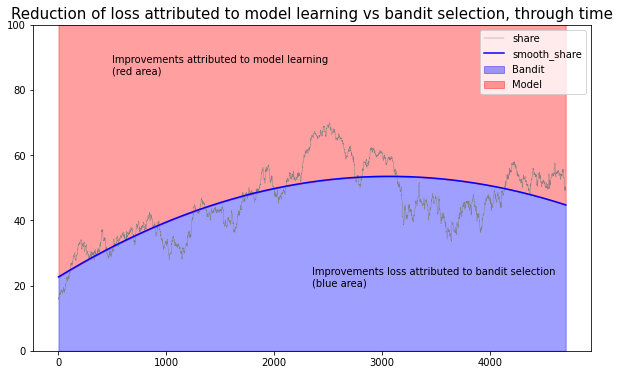

In [1163]:
ax = make_compare_area_plot(selection_effect)

## Isolating selection effect: selection on oracle trained models

In [1136]:
d_params = make_default_params()
bandit_oracle = OracleBandit(**d_params)

for i, (x, y) in tqdm.tqdm(enumerate(make_stream(dataset))):
    oracle_pred = bandit_oracle.predict_one(x, y)
    bandit_oracle.learn_one(x=x, y=y)        
    if i >= 1000:
        break

1000it [00:52, 19.16it/s]


<AxesSubplot:>

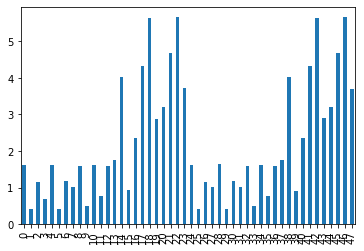

In [1137]:
pd.DataFrame(bandit_oracle.metric_values).mean().plot(kind="bar")

In [1146]:
bandits_select = {
    "epsilon" : EpsilonGreedyRegressor(epsilon=.1, **d_params),
    
    "random"  : RandomBanditRegressor(**d_params),
    "ucb"     : UCBRegressor(delta=None, explore_each_arm=0, **d_params),
}
bandits_rewards = {key:[] for key in bandits}

for i, (x, y) in tqdm.tqdm(enumerate(make_stream(dataset))):

    for bandit_label, bandit in bandits_select.items():
        y_pred = bandit.predict_one(x=x)
        bandit.learn_one(x=x, y=y, update_model=False)
        reward = bandit_oracle._compute_scaled_reward(y_pred=y_pred, y_true=y, update_scaler=False)
        bandits_rewards[bandit_label] += [reward]

1043it [00:02, 417.47it/s]

EpsilonGreedyRegressor
	MSE: 0.238526
	Best model id: 29
RandomBanditRegressor
	MSE: 1.820195
	Best model id: 25
UCBRegressor
	MSE: 0.878969
	Best model id: 29


2167it [00:04, 597.15it/s]

EpsilonGreedyRegressor
	MSE: 0.189897
	Best model id: 5
RandomBanditRegressor
	MSE: 1.844675
	Best model id: 25
UCBRegressor
	MSE: 0.627273
	Best model id: 25


3000it [00:05, 512.08it/s]

EpsilonGreedyRegressor
	MSE: 0.192665
	Best model id: 5
RandomBanditRegressor
	MSE: 1.855015
	Best model id: 25
UCBRegressor
	MSE: 0.523606
	Best model id: 5


<AxesSubplot:>

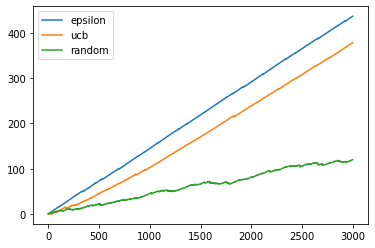

In [1147]:
pd.DataFrame(bandits_rewards).cumsum().plot()

<AxesSubplot:>

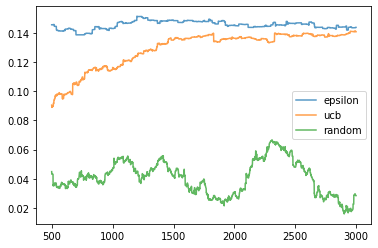

In [1148]:
pd.DataFrame(bandits_rewards).rolling(500).mean().plot(alpha=.75)

In [1142]:
metric_values_dict = {key:value.metric_values for key,value in bandits_select.items()}
metric_values_df = pd.DataFrame(metric_values_dict)

<AxesSubplot:title={'center':'Reduction of loss attributed to model learning vs bandit selection, through time'}>

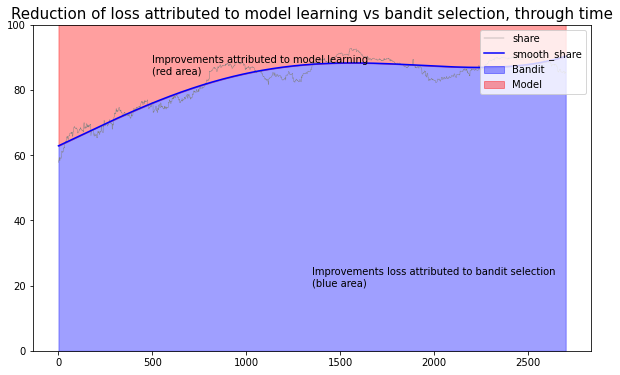

In [1144]:
selection_effect = make_compare_bandit_models_df(metric_values_df, rolling_value=300, smoothing_degree=4)
make_compare_area_plot(selection_effect)

<AxesSubplot:title={'center':'Cumsum of loss'}>

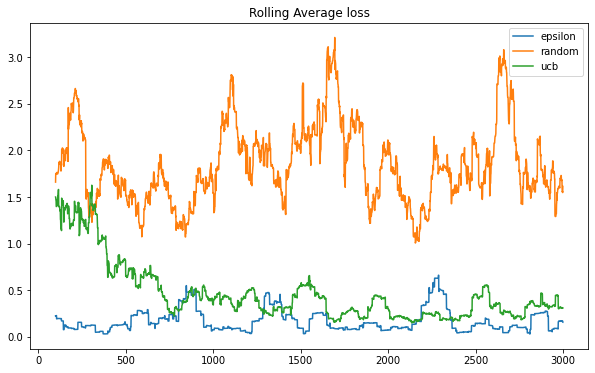

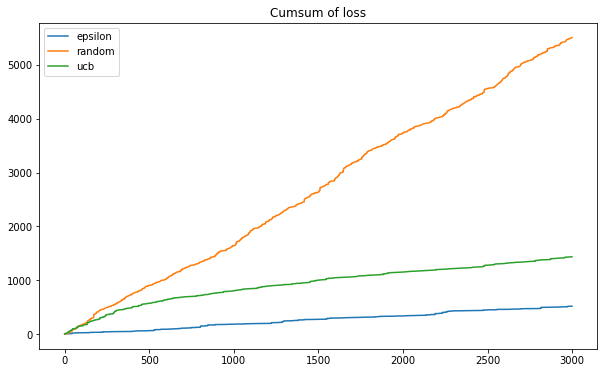

In [1145]:
metric_values_df.rolling(100).mean().plot(title="Rolling Average loss", figsize=FIGSIZE)
metric_values_df.cumsum().plot(title="Cumsum of loss", figsize=FIGSIZE)

## 3.3. Others (Regret analysis)

# 3. Introducing break